In [1]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.tri as tri
import datetime 
import time
#import netcdftime
import sys
import glob
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import os
from scipy.interpolate import griddata
import csv
#from mpl_toolkits.basemap import Basemap
from scipy import interpolate
import xarray as xr

This script is adapted from Arianna Valmassoi, credits go to her.

In [759]:
#define a color map for the plot later

colors_orig = [ (103,0,31),(178,24,43),(214,96,77),(244,165,130),(253,219,199),(255,255,255),(209,229,240),(146,197,222),(67,147,195),(33,102,172),(5,48,97)]
colorsm=[[a/255. for a in x] for x in colors_orig]
div_color= LinearSegmentedColormap.from_list( 'div_color', colorsm, N=39)
level=np.arange(-4,4,.2) #-.6,.5,.05)  #
bounds=level.tolist()
cmap = div_color
cmaplist = [cmap(i) for i in range(cmap.N,0,-1)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [470]:
#open dataset with temperature variable

datafile = xr.open_dataset("../Masterarbeit/crosssection_data/fc_DOM01_0002_URB_temp_grid.nc") 
#datafile = datafile.isel(height=slice(60))
a = datafile.variables['T'][0,:,:]

In [506]:
#open external paramters for topography and urban land use information

cor = xr.open_dataset('../Masterarbeit/crosssection_data/extpar_icon_grid_0026_R03B07_G.nc')
luf = cor.variables['LU_CLASS_FRACTION'][:,:]
topo = cor.variables['topography_c'][:]

In [472]:
clons  = np.rad2deg(datafile.variables["clon"])
clats  = np.rad2deg(datafile.variables["clat"])

In [609]:
#open height level file

hhl_file = xr.open_dataset("../Masterarbeit/crosssection_data/hhl.nc")
hhl = hhl_file.variables["HHL"][0,:,:]#[::-1]
hhl_f = hhl
### Full levels: because the levels are defined at half levels, it is corrected here
for k in range(1,hhl.shape[0]):
    hhl_f[k,:] = hhl[k,:] + (hhl[k,:]-hhl[k-1,:])/2


/srv/conda3/envs/py3-general/lib/python3.9/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda3/envs/py3-general/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda3/envs/py3-general/lib/python3.9/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instea

In [638]:
#extract index of the geographic regions where we want to do the interpolation

lar1 = 51.5
lar2 = 53.5
lor1 = 12
lor2 = 14


ind=[]
for i in range(0,clons.shape[0]):
    if ((clats[i]<lar2 and clats[i]>lar1) and (clons[i]>lor1 and clons[i]<lor2)): #find the indexes and select the values after
        ind.append(i)

In [675]:
#save it for Berlin to save some computational time when doing it again

np.save('ind_array_berlin.npy', ind)
#np.load would be the command to load it again

In [640]:
#defining the lon lat values for the cross section, where the interpolation is suppose to be mapped

lo_i = 12.1
la_i = 52.51
lo_f = 13.9
la_f = 52.53

lo_line = np.linspace(lo_i,lo_f,60)
la_line = np.linspace(la_i,la_f,60)
cross_line = np.vstack(( np.linspace(lo_i,lo_f,60), np.linspace(la_i,la_f,60) )).T
interp_method = 'cubic'
c = []
### Cross line as tuples
for i in range(1,cross_line.shape[0]+1):
    c.append(i)
lons=clons[ind]
lats=clats[ind]
lons=lons
i_c=np.vstack((lons,lats)).T

In [641]:
#initializing arrays

cross_val=np.zeros((hhl_f.shape[0]-1,len(cross_line)))
cross_fl =np.zeros((hhl_f.shape[0]-1,len(cross_line)))
cross_test =np.zeros((hhl_f.shape[0]-1,len(cross_line)))

In [682]:
# horizontal interpolation
for i in range(a.shape[0]-1,0,-1):
    hhlf_i = griddata(i_c,hhl_f[i,ind],cross_line,method=interp_method)
#    print(i, hhlf_i)
    test = griddata(i_c,a[i,ind],cross_line,method=interp_method)
#    print(i,test)
    val = test - np.nanmean(test)
#    print(val)
    cross_val[i,:] = val
    cross_fl[i,:] = hhlf_i
    cross_test[i,:] = c

In [685]:
#creating x-labels for the plot

x_labels = []
cross_line_lab = np.vstack([np.linspace(lo_i, lo_f, 60), np.linspace(la_i, la_f, 60)]).T
x_labels = [[round(pair[0], 2), round(pair[1], 2)] for pair in cross_line_lab]
print(x_labels)

[[12.1, 52.51], [12.13, 52.51], [12.16, 52.51], [12.19, 52.51], [12.22, 52.51], [12.25, 52.51], [12.28, 52.51], [12.31, 52.51], [12.34, 52.51], [12.37, 52.51], [12.41, 52.51], [12.44, 52.51], [12.47, 52.51], [12.5, 52.51], [12.53, 52.51], [12.56, 52.52], [12.59, 52.52], [12.62, 52.52], [12.65, 52.52], [12.68, 52.52], [12.71, 52.52], [12.74, 52.52], [12.77, 52.52], [12.8, 52.52], [12.83, 52.52], [12.86, 52.52], [12.89, 52.52], [12.92, 52.52], [12.95, 52.52], [12.98, 52.52], [13.02, 52.52], [13.05, 52.52], [13.08, 52.52], [13.11, 52.52], [13.14, 52.52], [13.17, 52.52], [13.2, 52.52], [13.23, 52.52], [13.26, 52.52], [13.29, 52.52], [13.32, 52.52], [13.35, 52.52], [13.38, 52.52], [13.41, 52.52], [13.44, 52.52], [13.47, 52.53], [13.5, 52.53], [13.53, 52.53], [13.56, 52.53], [13.59, 52.53], [13.63, 52.53], [13.66, 52.53], [13.69, 52.53], [13.72, 52.53], [13.75, 52.53], [13.78, 52.53], [13.81, 52.53], [13.84, 52.53], [13.87, 52.53], [13.9, 52.53]]


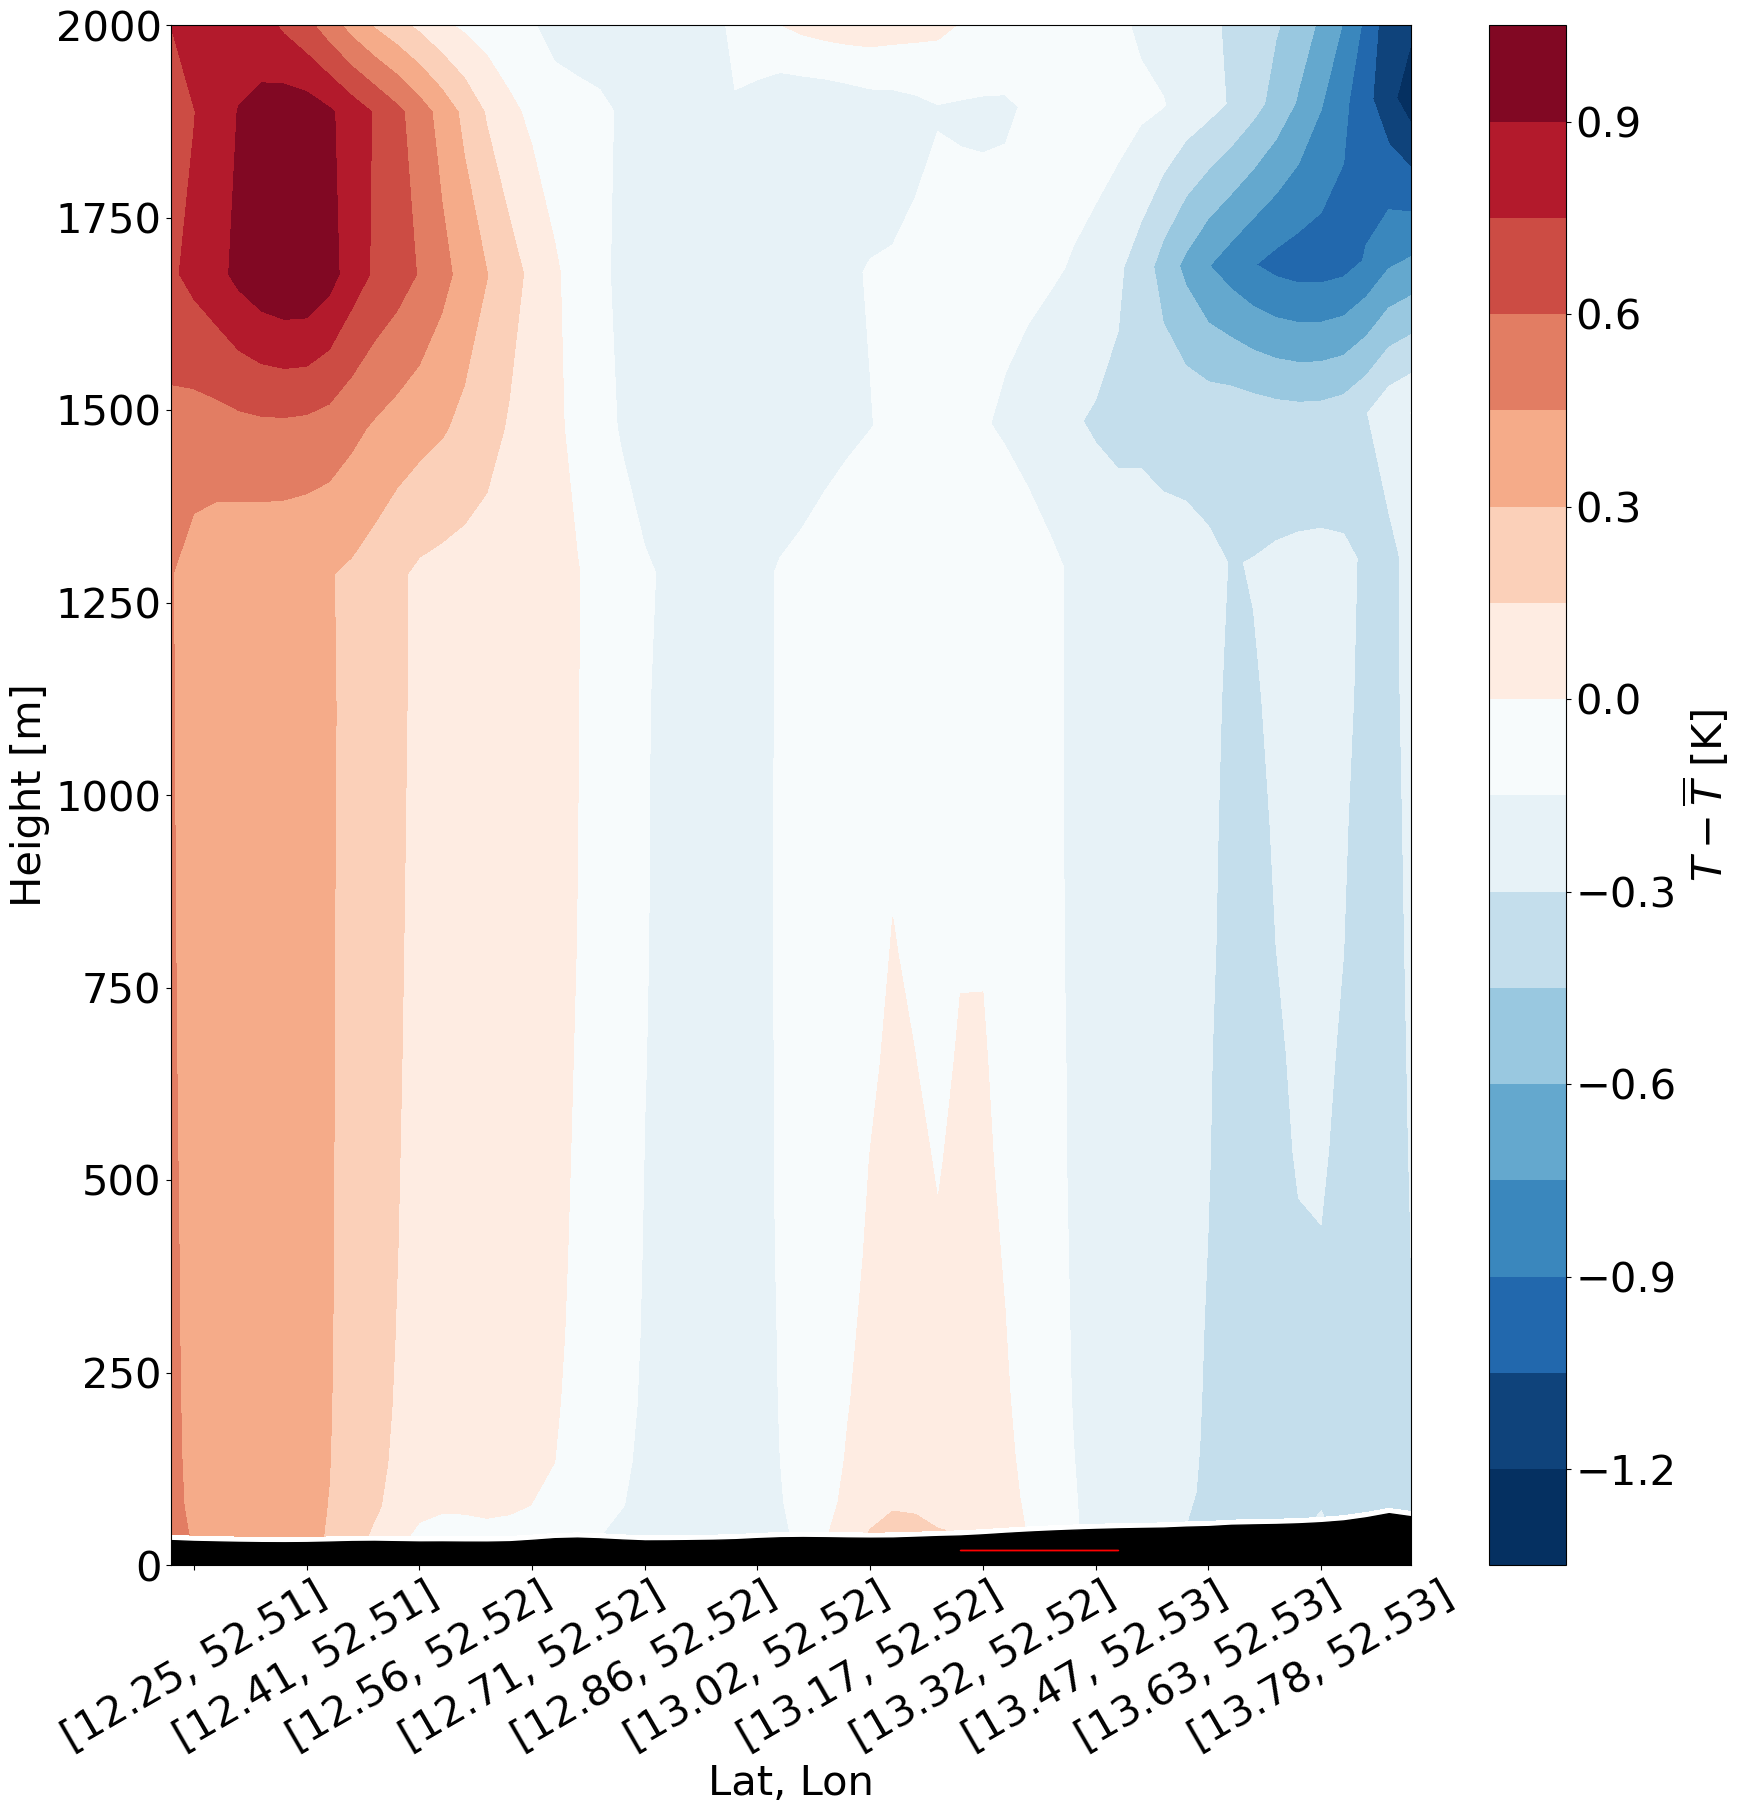

In [745]:
#Plot

params = {'axes.labelsize': 30,'axes.titlesize':30, 'legend.fontsize': 30, 'xtick.labelsize': 30, 
          'ytick.labelsize': 30}
plt.rcParams.update(params)

vmin = -1.5
vmax = 3

fig, ax =plt.subplots( figsize=(20, 20))
CS = plt.contourf(cross_test,cross_fl, cross_val,20, cmap=cmap)

## interp of invar fields:
topo_i = griddata(i_c,topo[ind],cross_line,method=interp_method)
lu_i = griddata(i_c,luf[18,ind],cross_line,method=interp_method)

plt.fill_between(c,-5,topo_i,color='k')

lu_urb = lu_i

for i in range(0,lu_i.shape[0]):
  if (lu_urb[i]<.6):
      lu_urb[i]= np.nan
  else:
      lu_urb[i]=20

plt.fill_between(c,20,lu_urb,color='r')

plt.ylim(0,2000)
plt.ylabel('Height [m]')
plt.xlabel('Lat, Lon')
plt.xlim(5,60)
plt.xticks(c[5::5],x_labels[5::5],rotation=30)
cbar = plt.colorbar(CS)
cbar.set_label('$T - \overline{T}$ [K]')
plt.show()

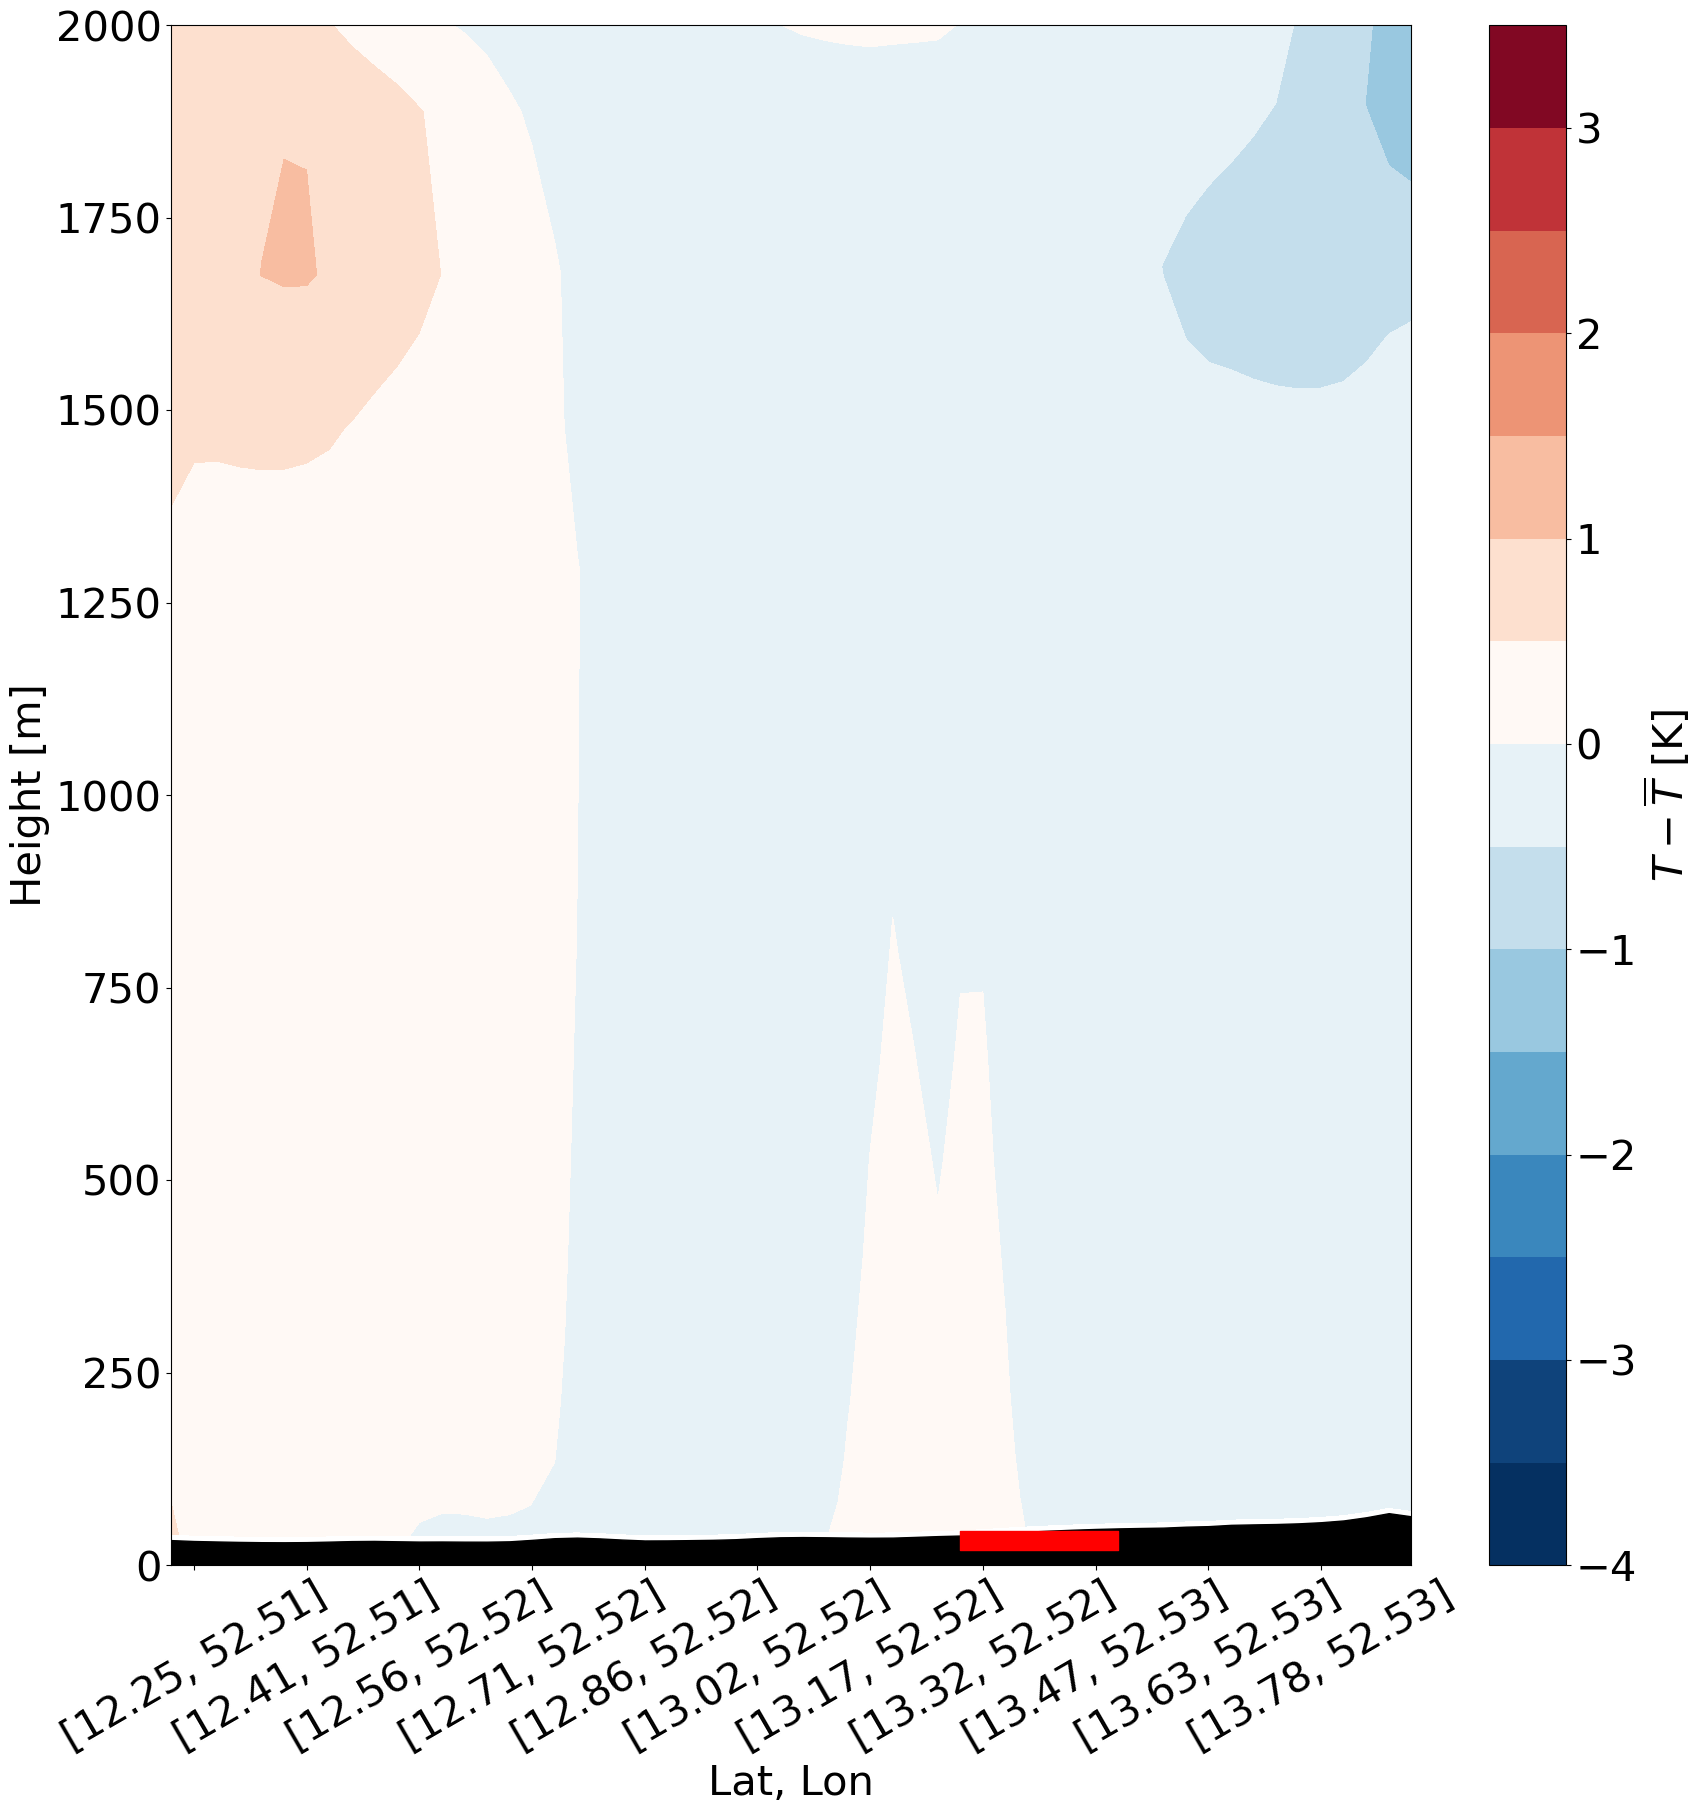

In [757]:
colors_orig = [(103,0,31),(178,24,43),(214,96,77),(244,165,130),(253,219,199),(255,255,255),(209,229,240),(146,197,222),(67,147,195),(33,102,172),(5,48,97)]
colorsm = [[a/255. for a in x] for x in colors_orig]

div_color = LinearSegmentedColormap.from_list('div_color', colorsm, N=30)
level = np.arange(-4, 4, .5)
bounds = level.tolist()
cmap = div_color
cmaplist = [cmap(i) for i in range(cmap.N,0,-1)]
cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
norm = BoundaryNorm(bounds, cmap.N)

params = {'axes.labelsize': 30,'axes.titlesize':30, 'legend.fontsize': 30, 'xtick.labelsize': 30, 
          'ytick.labelsize': 30}
plt.rcParams.update(params)

vmin = -3
vmax = 3

fig, ax = plt.subplots(figsize=(20, 20))
CS = plt.contourf(cross_test, cross_fl, cross_val, 20, cmap=cmap, norm=norm, levels=level)

## interp of invar fields:
topo_i = griddata(i_c, topo[ind], cross_line, method=interp_method)
lu_i = griddata(i_c, luf[18, ind], cross_line, method=interp_method)

plt.fill_between(c, -5, topo_i, color='k')

lu_urb = lu_i

for i in range(0, lu_i.shape[0]):
  if (lu_urb[i] < .6):
      lu_urb[i] = np.nan
  else:
      lu_urb[i] = 20

plt.fill_between(c, 45, lu_urb, color='r')

plt.ylim(0, 2000)
plt.ylabel('Height [m]')
plt.xlabel('Lat, Lon')
plt.xlim(5, 60)
plt.xticks(c[5::5], x_labels[5::5], rotation=30)
cbar = plt.colorbar(CS)
cbar.set_label('$T - \overline{T}$ [K]')
plt.show()
